# Flight Delay Prediction
## Classification - Is the flight delayed or not?

Target: **ArrDel15**

- <strong>Environment setup:</strong> import libraries and load the dataset
- <strong>Data Analysis:</strong> understand the meaning and the predictive power of the variables 
- <strong>Feature Selection:</strong> evaluate and keep only the most relevant variables
- <strong>Preprocessing:</strong> encode categorical variables and partition the dataset for training and testing
- <strong>Model design:</strong> train and test various models
- <strong>Performance evaluation:</strong> evaluate the models based on their metrics
- <strong>Explainability:</strong> understand how the model produces results

## Environment Setup

In [1]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy.stats import pointbiserialr

In [2]:
# Loading the combined flight and weather data
filepath = "Data/flight_and_weather.csv"
df = pd.read_csv(filepath, index_col=0)

# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")

/home/admin/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851436 entries, 0 to 1851435
Data columns (total 33 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Quarter          int64  
 2   Month            int64  
 3   DayofMonth       int64  
 4   FlightDate       object 
 5   OriginAirportID  int64  
 6   Origin           object 
 7   DestAirportID    int64  
 8   Dest             object 
 9   CRSDepTime       int64  
 10  DepTime          float64
 11  DepDelayMinutes  float64
 12  DepDel15         float64
 13  CRSArrTime       int64  
 14  ArrTime          float64
 15  ArrDelayMinutes  float64
 16  ArrDel15         float64
 17  Time_new         int64  
 18  windspeedKmph    int64  
 19  winddirDegree    int64  
 20  weatherCode      int64  
 21  precipMM         float64
 22  visibility       int64  
 23  pressure         int64  
 24  cloudcover       int64  
 25  DewPointF        int64  
 26  WindGustKmph     int64  
 27  tempF       

In [3]:
%%html
<style>
table {float:left}
</style>

### Eliminating Redundancy
|Column|Reason for elimination|
|:-|:-|
|FlightDate| The columns Year, Month and DayofMonth give this information in separate columns|
|OriginAirportID| It gives the same information as Origin|
|DestAirportID| It gives the same information as Dest|
|**CRSArrTime, ArrTime and ArrDelayMinutes**| They **leak information about target ArrDel15**|
|Time_new|It is a duplicate of time|
|date |It is a duplicate of FlightDate|
|airport|It is a duplicate of Origin|

In [4]:
# Dropping columns with redundant or duplicate data
df.drop(columns=["FlightDate",
                 "OriginAirportID",
                 "DestAirportID",
                 "CRSArrTime",
                 "ArrTime",
                 "ArrDelayMinutes",
                 "Time_new",
                 "date",
                 "airport"],
        inplace=True)
print(f"\nShape: {df.shape}", end="\n\n")
print(df.info())
# df.to_csv("./Data/flight_and_weather_without_redundant_info.csv")


Shape: (1851436, 24)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851436 entries, 0 to 1851435
Data columns (total 24 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Quarter          int64  
 2   Month            int64  
 3   DayofMonth       int64  
 4   Origin           object 
 5   Dest             object 
 6   CRSDepTime       int64  
 7   DepTime          float64
 8   DepDelayMinutes  float64
 9   DepDel15         float64
 10  ArrDel15         float64
 11  windspeedKmph    int64  
 12  winddirDegree    int64  
 13  weatherCode      int64  
 14  precipMM         float64
 15  visibility       int64  
 16  pressure         int64  
 17  cloudcover       int64  
 18  DewPointF        int64  
 19  WindGustKmph     int64  
 20  tempF            int64  
 21  WindChillF       int64  
 22  humidity         int64  
 23  time             int64  
dtypes: float64(5), int64(17), object(2)
memory usage: 353.1+ MB
None


## Data Analysis

Plotting the percentage of observations that are **Delayed (1.0)** and **Not Delayed (0.0).**

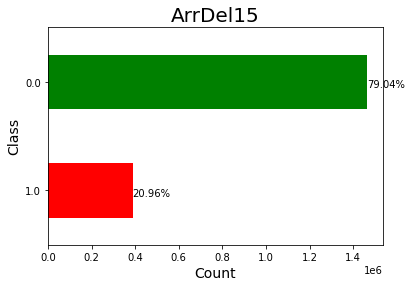

0.0    1463378
1.0     388058
Name: ArrDel15, dtype: int64


In [5]:
# Plotting the percentage of observations that fall under each class
ax = df["ArrDel15"].value_counts().sort_values().plot(kind="barh", color=["r", "g"])
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("ArrDel15", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(df["ArrDel15"].value_counts())
fig = ax.get_figure()
fig.savefig("Img/05_01_ArrDel15_Class_Imbalance.png")

### Point Biserial Correlation for Quantitative, Continuous Features with ArrDel15
A **correlation coefficient** measures the extent to which two variables tend to change together. The coefficient describes both the strength and the direction of the relationship.<br>
A **point-biserial correlation** is used to measure the strength and direction of the association that exists between **one continuous variable and one dichotomous variable.**

In [6]:
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
df["Origin"] = labelEncoder.fit_transform(df["Origin"])
df["Dest"] = labelEncoder.fit_transform(df["Dest"])

# get continuous and dichotomous data
categorical = ["Year", "Quarter", "Month", "DayofMonth", "Origin", "Dest", "CRSDepTime", "DepTime", "DepDel15", "winddirDegree", "weatherCode", "precipMM", "time", "ArrDel15"]
numeric = ["DepDelayMinutes", "windspeedKmph", "precipMM", "visibility", "pressure", "cloudcover", "DewPointF", "WindGustKmph", "tempF", "WindChillF", "humidity"]
target = df["ArrDel15"]

# pbc of first question
pbc = list()
for col in numeric:
    ans = pointbiserialr(df[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)
pbc_corr

,Feature,CorrCoeff,pValue
0,DepDelayMinutes,0.546150,0.000000e+00
1,precipMM,0.088363,0.000000e+00
2,windspeedKmph,0.085062,0.000000e+00
3,WindGustKmph,0.080279,0.000000e+00
4,DewPointF,0.038158,0.000000e+00
5,cloudcover,0.037821,0.000000e+00
6,tempF,0.035412,0.000000e+00
7,WindChillF,0.032019,0.000000e+00
8,humidity,-0.000729,3.213589e-01
9,visibility,-0.021870,1.255175e-194


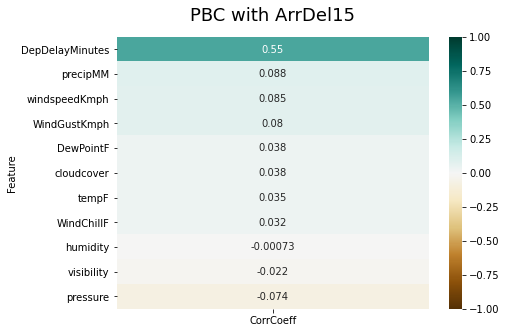

In [7]:
plt.figure(figsize=(7, 5))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("PBC with ArrDel15", fontdict={"fontsize":18}, pad=16);
plt.savefig("Img/05_02_PBC_ArrDel15.png")
del pbc_corr

### Spearman Correlation for Monotonic Relationships with Categorical Features
The **Spearman correlation** evaluates the monotonic relationship between **two continuous or ordinal variables**. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data

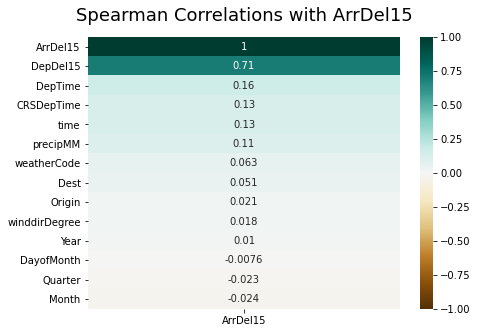

In [8]:
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df[categorical].corr(method="spearman")[["ArrDel15"]].sort_values(by="ArrDel15", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations with ArrDel15", fontdict={"fontsize":18}, pad=16)
plt.savefig("Img/05_03_Spearman_ArrDel15.png")
del heatmap

## Feature Selection
A random forest classifier has been modeled to rank the importance of the features in the entire dataset to visualize which features provide relevant information.<br>
**Note: Uncomment the below code if you want to re-train the model**

In [9]:
X = df.loc[:, df.columns != "ArrDel15"]
y = np.array(df.loc[:, df.columns == "ArrDel15"]["ArrDel15"])

# model = RandomForestClassifier(n_estimators=100,
#                       criterion="entropy", random_state=42, n_jobs=-1)

# model.fit(X, y)
# joblib.dump(model, "./Data/feature_importance_model.joblib")
model = joblib.load("./Data/feature_importance_model.joblib")
importances = model.feature_importances_
importances

array([0.00494138, 0.00522432, 0.01396747, 0.02620489, 0.01536883,
       0.03662587, 0.04980755, 0.06168722, 0.31320525, 0.19510444,
       0.02254369, 0.03456651, 0.01192306, 0.0101411 , 0.00600472,
       0.02375623, 0.02127661, 0.02633442, 0.02447963, 0.02544244,
       0.02584291, 0.02898795, 0.01656353])

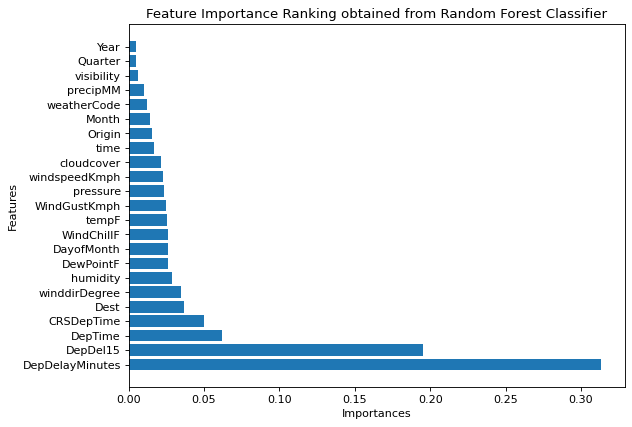

In [10]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")
plt.savefig("Img/05_04_Feature_Importances_RFC.png")
del importances
del model
del X
del y

## Preprocessing for Classification

In [11]:
# Encode the names of the 15 airports which are strings into a number range: 0 - 14
labelEncoder = LabelEncoder()
df["Origin"] = labelEncoder.fit_transform(df["Origin"])
df["Dest"] = labelEncoder.fit_transform(df["Dest"])
features = df.loc[:, df.columns != "ArrDel15"]
labels = np.asarray(df["ArrDel15"])
print(features.columns)
df[["Origin", "Dest"]]

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'Origin', 'Dest',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDel15', 'windspeedKmph',
       'winddirDegree', 'weatherCode', 'precipMM', 'visibility', 'pressure',
       'cloudcover', 'DewPointF', 'WindGustKmph', 'tempF', 'WindChillF',
       'humidity', 'time'],
      dtype='object')


,Origin,Dest
0,4,11
1,4,5
2,4,9
3,4,12
4,4,13
...,...,...
1851431,2,12
1851432,2,7
1851433,2,7
1851434,2,7


In [12]:
# Number of samples/observations/rows is greater than 100,000
print(f"\nDataset shape: {df.shape}")
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42)
print(f"features_train shape: {features_train.shape} | features_test shape: {features_test.shape}")
print(f"labels_train shape: {labels_train.shape} | labels_test shape: {labels_test.shape}")
# print(f"{features_train.shape[1]} Features: {features_train.columns.to_list()}")
del df


Dataset shape: (1851436, 24)
features_train shape: (1481148, 23) | features_test shape: (370288, 23)
labels_train shape: (1481148,) | labels_test shape: (370288,)


## Modeling Different Classifiers

### Logistic Regression

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292894
         1.0       0.89      0.68      0.77     77394

    accuracy                           0.92    370288
   macro avg       0.91      0.83      0.86    370288
weighted avg       0.91      0.92      0.91    370288



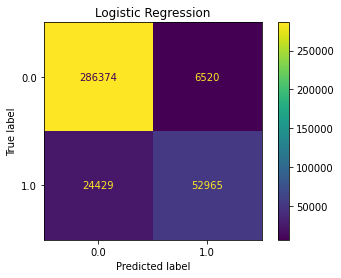

In [13]:
# model = LogisticRegression(n_jobs=-1)
# model.fit(features_train, labels_train)
# joblib.dump(model, "./Classifiers/LogisticRegression.joblib")
model = joblib.load("./Classifiers/LogisticRegression.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Logistic Regression")
print(conf_mat_plot)
plt.savefig("Img/05_05_LR_Confusion_Matrix")
del model
del model_pred

### Decision Tree Classifier

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92    292894
         1.0       0.68      0.71      0.69     77394

    accuracy                           0.87    370288
   macro avg       0.80      0.81      0.81    370288
weighted avg       0.87      0.87      0.87    370288



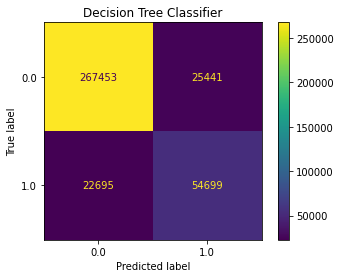

In [14]:
# model = DecisionTreeClassifier()
# model.fit(features_train, labels_train)
# joblib.dump(model, "./Classifiers/DecisionTreeClassifier.joblib")
model = joblib.load("./Classifiers/DecisionTreeClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Decision Tree Classifier")
print(conf_mat_plot)
plt.savefig("Img/05_06_DTC_Confusion_Matrix")
del model
del model_pred

### XGBoost

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292894
         1.0       0.90      0.68      0.78     77394

    accuracy                           0.92    370288
   macro avg       0.91      0.83      0.86    370288
weighted avg       0.92      0.92      0.91    370288



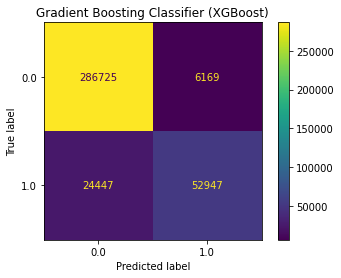

In [15]:
# model = GradientBoostingClassifier()
# model.fit(features_train, labels_train)
# joblib.dump(model, "./Classifiers/GradientBoostingClassifier.joblib")
model = joblib.load("./Classifiers/GradientBoostingClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Gradient Boosting Classifier (XGBoost)")
print(conf_mat_plot)
plt.savefig("Img/05_07_GBC_Confusion_Matrix")
del model
del model_pred

### Random Forest

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    292894
         1.0       0.88      0.70      0.78     77394

    accuracy                           0.92    370288
   macro avg       0.90      0.84      0.87    370288
weighted avg       0.92      0.92      0.91    370288



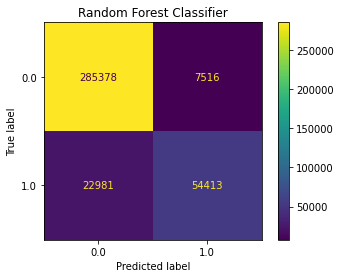

In [16]:
# model = RandomForestClassifier(n_jobs=-1)
# model.fit(features_train, labels_train)
# joblib.dump(model, "./Classifiers/RandomForestClassifier.joblib")
model = joblib.load("./Classifiers/RandomForestClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Random Forest Classifier")
print(conf_mat_plot)
plt.savefig("Img/05_08_RFC_Confusion_Matrix")
del model
del model_pred

### Extra Trees Classifier

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94    292894
         1.0       0.82      0.73      0.77     77394

    accuracy                           0.91    370288
   macro avg       0.87      0.84      0.86    370288
weighted avg       0.91      0.91      0.91    370288



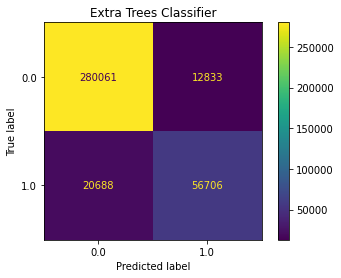

In [17]:
model = ExtraTreesClassifier(n_jobs=-1)
model.fit(features_train, labels_train)
# joblib.dump(model, "./Classifiers/ExtraTreesClassifier.joblib")
# model = joblib.load("./Classifiers/ExtraTreesClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Extra Trees Classifier")
print(conf_mat_plot)
plt.savefig("Img/05_09_ETC_Confusion_Matrix")

## Performance Evaluation

In [18]:
# Setup
perf_df = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

# Handling Extra Trees Classifier separately due to memory constraints
fpr, tpr, _ = roc_curve(labels_test,  model_pred)
auc = roc_auc_score(labels_test, model_pred)
# Record the results
perf_df = perf_df.append({"classifiers": "ExtraTreesClassifier",
                                        "fpr": fpr, 
                                        "tpr": tpr, 
                                        "auc": auc}, ignore_index=True)
del model
del model_pred

classifiers = ["LogisticRegression", "DecisionTreeClassifier", "GradientBoostingClassifier", "RandomForestClassifier"]
for clf in classifiers:
    # Load the trained classifiers
    model = joblib.load(f"./Classifiers/{clf}.joblib")
    model_pred = model.predict(features_test)
    fpr, tpr, _ = roc_curve(labels_test,  model_pred)
    auc = roc_auc_score(labels_test, model_pred)
    # Record the results
    perf_df = perf_df.append({"classifiers": clf,
                                        "fpr": fpr, 
                                        "tpr": tpr, 
                                        "auc": auc}, ignore_index=True)
    del model
    del model_pred

# Set name of the classifiers as index labels
perf_df.set_index("classifiers", inplace=True)

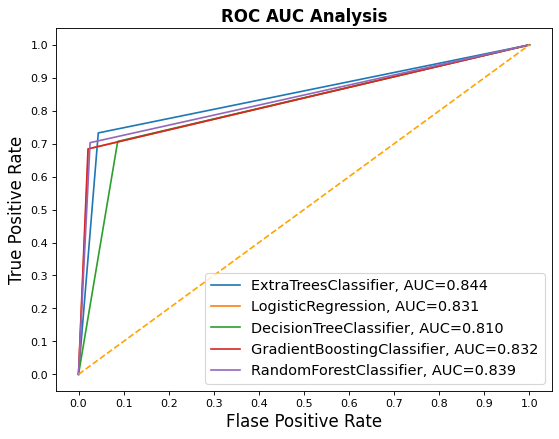

In [19]:
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in perf_df.index:
    plt.plot(perf_df.loc[clf_name]["fpr"], 
             perf_df.loc[clf_name]["tpr"], 
             label="{}, AUC={:.3f}".format(clf_name, perf_df.loc[clf_name]["auc"]))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title("ROC AUC Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.show()
fig.savefig("Img/05_10_Classifiers_ROC_AUC.png")

## Explanation
The <strong>Receiver Operator Characteristic (ROC) curve</strong> is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The <strong>Area Under the Curve (AUC)</strong> is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
<br><br>
**The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.**

|AUC Value|Meaning|
|:--|:--|
|AUC = 1| The classifier is able to **perfectly distinguish** between all the Positive and the Negative class points correctly.|
|AUC = 0| The classifier would be predicting **all Negatives as Positives, and all Positives as Negatives**|
|0.5 < AUC < 1| There is a high chance that the classifier will be able to distinguish the classes i.e. more numbers of True positives and True negatives than False negatives and False positives|
|AUC=0.5| The classifier is not able to distinguish between Positive and Negative class points i.e. either the classifier is predicting random class or constant class for all the data points|